In [1]:
pip install earthengine-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 4.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install earthengine-api geemap matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.9.0-py3-none-any.whl size=11003 sha256=b62eea70186ebd3ef77a2448c73900e04cfa7451d1fae0e1e873d610b2add855
  Stored in directory: /Users/Sofia/Library/Caches/pip/wheels/e0/e8/fc/8ab8aa326e33bc066ccd5f3ca9646eab4299881af933f94f09
Successfully built pyperclip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import ee
import geemap
import matplotlib
print("Libraries installed successfully!")

Libraries installed successfully!


In [14]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Initialize GEE
try:
    ee.Initialize()
    print("GEE Initialized Successfully!")
except Exception as e:
    print("Initialization failed:", str(e))
    print("Run 'earthengine authenticate' in terminal if credentials are missing.")
    raise

# Define Southern Spain region (Andalusia, Murcia)
southern_spain = ee.Geometry.Rectangle([-7.5, 36, -1, 38.5])

# Create an interactive map
Map = geemap.Map()
Map.centerObject(southern_spain, 8)

# 1. Load Sentinel-2 for NDVI (crop health)
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterBounds(southern_spain)
      .filterDate('2024-03-01', '2024-09-30')  # Growing season (olives, tomatoes)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .median())

# Calculate NDVI
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Add NDVI to map
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}
Map.addLayer(ndvi, ndvi_vis, 'NDVI')

# 2. Load CHIRPS precipitation (water availability for Almería, Murcia)
precip = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .filterBounds(southern_spain)
          .filterDate('2024-01-01', '2024-12-31')
          .sum())

# Add precipitation to map
precip_vis = {'min': 0, 'max': 1000, 'palette': ['dry', 'blue']}
Map.addLayer(precip, precip_vis, 'Precipitation (mm)')

# 3. Load soil texture (suitability for olives, citrus)
soil = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02').clip(southern_spain)
Map.addLayer(soil, {}, 'Soil Texture')

# 4. Land use classification (identify farmland, e.g., Almería greenhouses)
corine = ee.Image('COPERNICUS/CORINE/V20/100m/2018').clip(southern_spain)
training = s2.select(['B2', 'B3', 'B4', 'B8'])
samples = training.sampleRegions(
    collection=corine,
    properties=['landcover'],
    scale=10
)
classifier = ee.Classifier.smileRandomForest(50).train(
    features=samples,
    classProperty='landcover',
    inputProperties=['B2', 'B3', 'B4', 'B8']
)
classified = training.classify(classifier)

# Add land use to map
land_use_vis = {'min': 0, 'max': 44, 'palette': ['green', 'brown', 'gray']}
Map.addLayer(classified, land_use_vis, 'Land Use')

# 5. NDVI time-series chart (track crop health)
ndvi_time_series = (ee.ImageCollection('COPERNICUS/S2_SR')
                    .filterBounds(southern_spain)
                    .filterDate('2024-01-01', '2024-12-31')
                    .map(lambda image: image.normalizedDifference(['B8', 'B4'])
                         .rename('NDVI')
                         .set('system:time_start', image.get('system:time_start'))))

# Extract NDVI values
try:
    ndvi_chart = geemap.ee_to_pandas(
        ndvi_time_series.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=southern_spain,
            scale=10
        ).select(['NDVI'])
    )

    # Plot NDVI time-series
    plt.figure(figsize=(10, 6))
    plt.plot(ndvi_chart.index, ndvi_chart['NDVI'], 'b-', label='Mean NDVI')
    plt.title('NDVI Time-Series for Southern Spain (2024)')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.grid(True)
    plt.legend()
    plt.savefig('ndvi_timeseries.png')
    plt.close()
    print("NDVI time-series plot saved as 'ndvi_timeseries.png'")
except Exception as e:
    print("Error generating NDVI chart:", str(e))

# 6. Export NDVI map to Drive
try:
    task = ee.batch.Export.image.toDrive(
        image=ndvi,
        description='SouthernSpain_NDVI_2024',
        scale=10,
        region=southern_spain,
        maxPixels=1e13
    )
    task.start()
    print("Export task started. Check Google Drive for 'SouthernSpain_NDVI_2024'.")
except Exception as e:
    print("Error starting export:", str(e))

# Display the map
Map

Initialization failed: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.
Run 'earthengine authenticate' in terminal if credentials are missing.


EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

In [17]:
import ee
import geemap.core as geemap

In [20]:
import ee
ee.Authenticate()
ee.Initialize()



Enter verification code:  4/1Ab_5qlmyup9QRGX_wkj5s4DvswjZ-lH_hRdkc6KFeXQaqyUjSU_AsY2epVs



Successfully saved authorization token.


In [21]:
pip install matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [24]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define area of interest: Andalusia (or use a bounding box)
aoi = ee.Geometry.Rectangle([-6.5, 36.8, -2.5, 38.7])  # approx. Andalusia

# Load Sentinel-2 surface reflectance data
sentinel = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(aoi) \
    .filterDate('2023-04-01', '2023-05-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Calculate median image
median = sentinel.median()

# Calculate NDVI = (NIR - Red) / (NIR + Red)
ndvi = median.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Print to make sure it's defined
print("NDVI ready.")

# Export or visualize (optional — would need folium or export task)


NDVI ready.


In [25]:
import ee
import folium
import geemap.foliumap as geemap

# Authenticate and initialize
ee.Initialize()

# Define area of interest
aoi = ee.Geometry.Rectangle([-6.5, 36.8, -2.5, 38.7])  # Andalusia

# Create a folium map centered on southern Spain
m = geemap.Map(center=[37.3, -4.5], zoom=7)

# === Layer 1: NDVI (Vegetation Health) ===
sentinel = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(aoi) \
    .filterDate('2023-04-01', '2023-05-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()

ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

ndvi_vis = {
    'min': 0.0,
    'max': 0.8,
    'palette': ['white', 'green']
}

m.addLayer(ndvi, ndvi_vis, 'NDVI')

# === Layer 2: Surface Water ===
water = ee.Image("JRC/GSW1_3/GlobalSurfaceWater") \
    .select("occurrence")

water_vis = {
    'min': 0,
    'max': 100,
    'palette': ['white', 'blue']
}

m.addLayer(water, water_vis, 'Surface Water Occurrence')

# === Layer 3: Land Cover ===
landcover = ee.Image("ESA/WorldCover/v100/2020").clip(aoi)

landcover_vis = {
    'min': 10,
    'max': 100,
    'palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000',
                'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75']
}

m.addLayer(landcover, landcover_vis, 'Land Cover')

# Add layer control
m.addLayerControl()

# Show map
m


/opt/miniconda3/envs/sds2024/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for JRC/GSW1_3/GlobalSurfaceWater! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater

  warnings.warn(warning, category=DeprecationWarning)


In [27]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Initialize()

# Define a SMALLER area of interest: Example ~Almería
aoi = ee.Geometry.Rectangle([-2.5, 36.6, -1.8, 37.2])  # smaller box

# Create a geemap map object with layer controls
Map = geemap.Map(center=[36.9, -2.1], zoom=10)

# Sentinel-2 NDVI
sentinel = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(aoi) \
    .filterDate('2023-04-01', '2023-05-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()

ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_vis = {'min': 0, 'max': 0.8, 'palette': ['white', 'green']}
Map.addLayer(ndvi.clip(aoi), ndvi_vis, 'NDVI')

# Surface Water (JRC)
water = ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select("occurrence")
water_vis = {'min': 0, 'max': 100, 'palette': ['white', 'blue']}
Map.addLayer(water.clip(aoi), water_vis, 'Surface Water')

# ESA WorldCover Land Use
landcover = ee.Image("ESA/WorldCover/v100/2020")
landcover_vis = {'min': 10, 'max': 100, 'palette': ['006400', 'ffbb22', 'ffff4c',
                                                    'f096ff', 'fa0000', 'b4b4b4',
                                                    'f0f0f0', '0064c8', '0096a0', '00cf75']}
Map.addLayer(landcover.clip(aoi), landcover_vis, 'Land Cover')

# Add layer control (this gives you checkboxes!)
Map.addLayerControl()

# Display the map
Map

Map.to_html('my_map.html')



In [28]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Initialize()

# Define the smaller area of interest (Almería)
aoi = ee.Geometry.Rectangle([-2.5, 36.6, -1.8, 37.2])  # smaller box

# Create a geemap map object
Map = geemap.Map(center=[36.9, -2.1], zoom=10)

# Sentinel-2 NDVI
sentinel = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(aoi) \
    .filterDate('2023-04-01', '2023-05-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()

ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_vis = {'min': 0, 'max': 0.8, 'palette': ['white', 'green']}
Map.addLayer(ndvi.clip(aoi), ndvi_vis, 'NDVI')

# Surface Water (JRC)
water = ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select("occurrence")
water_vis = {'min': 0, 'max': 100, 'palette': ['white', 'blue']}
Map.addLayer(water.clip(aoi), water_vis, 'Surface Water')

# ESA WorldCover Land Use
landcover = ee.Image("ESA/WorldCover/v100/2020")
landcover_vis = {'min': 10, 'max': 100, 'palette': ['006400', 'ffbb22', 'ffff4c',
                                                    'f096ff', 'fa0000', 'b4b4b4',
                                                    'f0f0f0', '0064c8', '0096a0', '00cf75']}
Map.addLayer(landcover.clip(aoi), landcover_vis, 'Land Cover')

# Export map to HTML file
Map.to_html('my_map.html')

print("Map has been exported as my_map.html. Please open it in a web browser.")


Map has been exported as my_map.html. Please open it in a web browser.


In [56]:
import ee
import geemap
import geopandas as gpd
import zipfile
import os

# 1. Load shapefile directly
shapefile_path = 'data/examplefarm.shp'  # <-- update this to match your file path
farm_gdf = gpd.read_file(shapefile_path)

# 2. Reproject to EPSG:4326 (if needed)
farm_gdf = farm_gdf.to_crs(epsg=4326)

# 3. Initialize Earth Engine and convert shapefile to EE Feature
ee.Initialize()
farm_ee = geemap.gdf_to_ee(farm_gdf)

# 4. Center map on your farm
Map = geemap.Map(center=[farm_gdf.geometry.centroid.y[0], farm_gdf.geometry.centroid.x[0]], zoom=14)
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')




# 3. Convert to Earth Engine Feature
ee.Initialize()
farm_ee = geemap.gdf_to_ee(farm_gdf)

# 4. Create map
Map = geemap.Map(center=[farm_gdf.geometry.centroid.y[0], farm_gdf.geometry.centroid.x[0]], zoom=14)

# 5. NDVI (vegetation health)
ndvi = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .median() \
    .normalizedDifference(['B8', 'B4']).rename('NDVI')
Map.addLayer(ndvi.clip(farm_ee), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI (April 2024)')

# 6. NDWI (water index)
ndwi = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .median() \
    .normalizedDifference(['B3', 'B8']).rename('NDWI')
Map.addLayer(ndwi.clip(farm_ee), {'min': -1, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI (April 2024)')

# 7. Land cover
landcover = ee.Image("ESA/WorldCover/v100/2020").select('Map')
Map.addLayer(landcover.clip(farm_ee), {'min': 10, 'max': 100, 'palette': [
    '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000',
    'b4b4b4', 'f0f0f0', '0032c8', '0096a0', '005000', '00ff00'
]}, 'Land Cover (ESA 2020)')

# 8. Slope
elevation = ee.Image("USGS/SRTMGL1_003")
slope = ee.Terrain.slope(elevation)
Map.addLayer(slope.clip(farm_ee), {'min': 0, 'max': 30, 'palette': ['white', 'black']}, 'Slope')



# 10. Protected areas
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
Map.addLayer(wdpa.filterBounds(farm_ee), {'color': 'blue'}, 'Protected Areas')

# 11. Farm boundary
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')

# 12. Add a legend
legend_dict = {
    'NDVI (Healthy Vegetation)': 'green',
    'NDWI (Water)': 'blue',
    'Slope': 'black',
    'Soil Organic Carbon': '#41ab5d',
    'Protected Area': 'purple'
}

Map.add_legend(title='Layer Legend', legend_dict=legend_dict)




# 13. Final touches
Map.addLayerControl()
Map


Exception: The legend colors must be a list of tuples.

In [67]:
import ee
import geemap
import geopandas as gpd

# 1. Load shapefile directly
shapefile_path = 'data/examplefarm.shp'  # <-- update this to match your file path
farm_gdf = gpd.read_file(shapefile_path)

# 2. Reproject to EPSG:4326 (if needed)
farm_gdf = farm_gdf.to_crs(epsg=4326)

# 3. Initialize Earth Engine and convert shapefile to EE Feature
ee.Initialize()
farm_ee = geemap.gdf_to_ee(farm_gdf)

# 4. Center map on your farm
Map = geemap.Map(center=[farm_gdf.geometry.centroid.y[0], farm_gdf.geometry.centroid.x[0]], zoom=14)
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')

# 5. NDVI (vegetation health)
ndvi = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .median() \
    .normalizedDifference(['B8', 'B4']).rename('NDVI')
Map.addLayer(ndvi.clip(farm_ee), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI (April 2024)')

# 6. NDWI (water index)
ndwi = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .median() \
    .normalizedDifference(['B3', 'B8']).rename('NDWI')
Map.addLayer(ndwi.clip(farm_ee), {'min': -1, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI (April 2024)')

# 7. Land cover
landcover = ee.Image("ESA/WorldCover/v100/2020").select('Map')
Map.addLayer(landcover.clip(farm_ee), {'min': 10, 'max': 100, 'palette': [
    '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000',
    'b4b4b4', 'f0f0f0', '0032c8', '0096a0', '005000', '00ff00'
]}, 'Land Cover (ESA 2020)')

# 8. Slope
elevation = ee.Image("USGS/SRTMGL1_003")
slope = ee.Terrain.slope(elevation)
Map.addLayer(slope.clip(farm_ee), {'min': 0, 'max': 30, 'palette': ['white', 'black']}, 'Slope')

# 10. Protected areas
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
Map.addLayer(wdpa.filterBounds(farm_ee), {'color': 'blue'}, 'Protected Areas')

# 11. Farm boundary
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')

# 12. Custom HTML legend box
legend_html = """
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border-radius: 5px; border: 1px solid black; opacity: 0.7; z-index: 9999;">
        <strong>Layer Legend</strong><br><br>
        <span style="color: green;">&#9632;</span> NDVI (Healthy Vegetation)<br>
        <span style="color: blue;">&#9632;</span> NDWI (Water)<br>
        <span style="color: black;">&#9632;</span> Slope<br>
        <span style="color: #41ab5d;">&#9632;</span> Soil Organic Carbon<br>
        <span style="color: purple;">&#9632;</span> Protected Area<br>
    </div>
"""
Map.add_html(legend_html)

# 13. Final touches
Map.addLayerControl()
Map.save("farm_map.html")


In [66]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

# Initialize GEE
ee.Initialize()

# 1. Load shapefile
shapefile_path = 'data/examplefarm.shp'  # Update to your shapefile path
if not os.path.exists(shapefile_path):
    raise FileNotFoundError(f"Shapefile not found at {shapefile_path}. Ensure path is correct or use coordinates.")
farm_gdf = gpd.read_file(shapefile_path)

# 2. Reproject to EPSG:4326
farm_gdf = farm_gdf.to_crs(epsg=4326)

# 3. Convert to EE Feature
farm_ee = geemap.gdf_to_ee(farm_gdf)

# Alternative: Coordinates (uncomment if no shapefile)
# farm_coords = [
#     [-2.5, 36.85], [-2.5, 36.86], [-2.49, 36.86], [-2.49, 36.85], [-2.5, 36.85]
# ]
# farm_ee = ee.Geometry.Polygon(farm_coords)

# Load CSV points (optional)
# points = ee.FeatureCollection('users/your_username/farm_points')

# 4. Create map
centroid = farm_gdf.geometry.centroid
Map = geemap.Map(center=[centroid.y[0], centroid.x[0]], zoom=14)

# 5. NDVI (Sentinel-2)
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_vis = {'min': 0.1, 'max': 0.5, 'palette': ['white', 'green']}

# 6. NDWI (water index)
ndwi = s2.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndwi_vis = {'min': -1, 'max': 1, 'palette': ['white', 'blue']}

# 7. Land Cover (ESA WorldCover)
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')
landcover_vis = {
    'min': 10, 'max': 100,
    'palette': [
        '006400',  # Tree cover
        'ffbb22',  # Shrubland
        'ffff4c',  # Grassland
        'f096ff',  # Cropland
        'fa0000',  # Built-up
        'b4b4b4',  # Bare/sparse
        'f0f0f0',  # Snow/ice
        '0064c8',  # Water bodies
        '0096a0',  # Herbaceous wetland
        '00cf75',  # Mangroves
        'fae6a0'   # Moss/lichen
    ]
}

# 8. Slope (SRTM)
elevation = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(elevation)
slope_vis = {'min': 0, 'max': 30, 'palette': ['white', 'black']}

# 9. Soil Organic Carbon (OpenLandMap)
soil = ee.Image('OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02').select('b0').clip(farm_ee)
soil_vis = {'min': 2, 'max': 5, 'palette': ['ffffa0', 'f7fcb9', 'd9f0a3', 'addd8e', '78c679', '41ab5d', '238443', '005b29', '004b29', '012b13', '00120b']}

# 10. Precipitation (CHIRPS)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .sum()
precip_vis = {'min': 0, 'max': 1000, 'palette': ['beige', 'blue']}

# 11. Drought (SPEI)
drought = ee.ImageCollection('CSIC/SPEI/2_8') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .mean()
drought_vis = {'min': -3, 'max': 2, 'palette': ['ff4819', '0095ff']}

# 12. Protected Areas (WDPA)
wdpa = ee.FeatureCollection('WCMC/WDPA/current/polygons')
wdpa_vis = {'color': 'purple', 'fillColor': 'purple', 'fillOpacity': 0.3}

# 13. Biodiversity Hotspots
hotspots = ee.FeatureCollection('RESOLVE/BIODIVERSITY-HOTSPOTS/2019').filterBounds(farm_ee)
hotspots_vis = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.2}

# 14. Add layers
Map.addLayer(ndvi.clip(farm_ee), ndvi_vis, 'NDVI (April 2024)')
Map.addLayer(ndwi.clip(farm_ee), ndwi_vis, 'NDWI (April 2024)')
Map.addLayer(landcover.clip(farm_ee), landcover_vis, 'Land Cover (ESA 2020)')
Map.addLayer(slope.clip(farm_ee), slope_vis, 'Slope')
Map.addLayer(soil, soil_vis, 'Soil Organic Carbon')
Map.addLayer(precip.clip(farm_ee), precip_vis, 'Precipitation (mm)')
Map.addLayer(drought.clip(farm_ee), drought_vis, 'Drought (SPEI)')
Map.addLayer(wdpa.filterBounds(farm_ee), wdpa_vis, 'Protected Areas')
Map.addLayer(hotspots, hotspots_vis, 'Biodiversity Hotspots')
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')
# Map.addLayer(points, {'color': 'red'}, 'Farm Points')  # Uncomment if CSV

# 15. Legend
legend_dict = {
    'NDVI (Healthy Vegetation)': 'green',
    'NDWI (Water)': 'blue',
    'Slope': 'black',
    'Soil Organic Carbon': '#41ab5d',
    'Precipitation': 'blue',
    'Drought (SPEI)': '#0095ff',
    'Land Cover (Cropland)': '#f096ff',
    'Protected Area': 'purple',
    'Biodiversity Hotspot': 'red'
}
Map.add_legend(title='Layer Legend', legend_dict=legend_dict)

# 16. Layer control
Map.addLayerControl()

# 17. NDVI time-series chart
ndvi_time_series = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI') \
         .set('system:time_start', image.get('system:time_start')))

def get_ndvi_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=farm_ee,
        scale=10
    )
    return ee.Feature(None, {
        'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'),
        'ndvi': stats.get('NDVI')
    })

ndvi_stats = ndvi_time_series.map(get_ndvi_stats).getInfo()
dates = [item['properties']['date'] for item in ndvi_stats['features']]
ndvi_values = [item['properties']['ndvi'] for item in ndvi_stats['features']]

plt.figure(figsize=(10, 6))
plt.plot(dates, ndvi_values, 'b-', label='NDVI')
plt.title('NDVI Time-Series for Farm (2024)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 18. Export NDVI
task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description='Farm_NDVI_2024',
    scale=10,
    region=farm_ee,
    maxPixels=1e13
)
task.start()

# 19. Check hotspot/protected area overlap
hotspot_overlap = hotspots.filterBounds(farm_ee).size().getInfo()
wdpa_overlap = wdpa.filterBounds(farm_ee).size().getInfo()
print('Biodiversity Hotspot Overlap:', 'Farm is within a biodiversity hotspot (Mediterranean Basin)' if hotspot_overlap > 0 else 'Farm is not within a biodiversity hotspot')
print('Protected Area Overlap:', 'Farm is within a protected area' if wdpa_overlap > 0 else 'Farm is not within a protected area')

# 20. Display map
Map.save("farm_map.html")

EEException: Collection.loadTable: Collection asset 'RESOLVE/BIODIVERSITY-HOTSPOTS/2019' not found.

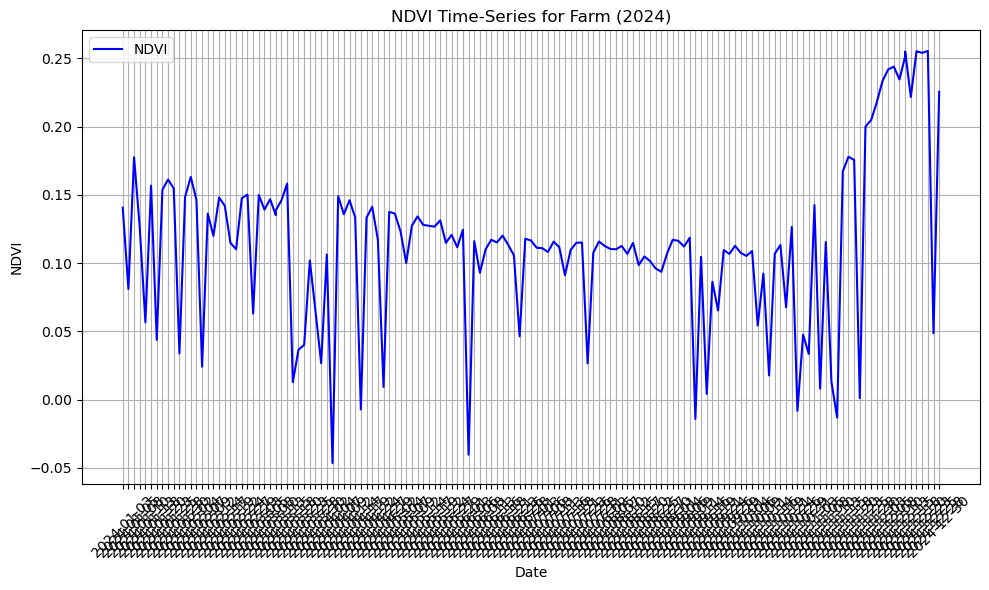

Mediterranean Ecoregion Overlap: Farm is within Mediterranean Basin ecoregion
Protected Area Overlap: Farm is not within a protected area


In [68]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

# Initialize GEE
ee.Initialize()

# 1. Load shapefile
shapefile_path = 'data/examplefarm.shp'  # Update to your shapefile path
if not os.path.exists(shapefile_path):
    raise FileNotFoundError(f"Shapefile not found at {shapefile_path}. Ensure path is correct or use coordinates.")
farm_gdf = gpd.read_file(shapefile_path)

# 2. Reproject to EPSG:4326
farm_gdf = farm_gdf.to_crs(epsg=4326)

# 3. Convert to EE Feature
farm_ee = geemap.gdf_to_ee(farm_gdf)

# Alternative: Coordinates (uncomment if no shapefile)
# farm_coords = [
#     [-2.5, 36.85], [-2.5, 36.86], [-2.49, 36.86], [-2.49, 36.85], [-2.5, 36.85]
# ]
# farm_ee = ee.Geometry.Polygon(farm_coords)

# Load CSV points (optional)
# points = ee.FeatureCollection('users/your_username/farm_points')

# 4. Create map
centroid = farm_gdf.geometry.centroid
Map = geemap.Map(center=[centroid.y[0], centroid.x[0]], zoom=14)

# 5. NDVI (Sentinel-2)
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(farm_ee) \
    .filterDate('2024-04-01', '2024-04-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_vis = {'min': 0.1, 'max': 0.5, 'palette': ['white', 'green']}

# 6. NDWI (water index)
ndwi = s2.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndwi_vis = {'min': -1, 'max': 1, 'palette': ['white', 'blue']}

# 7. Land Cover (ESA WorldCover)
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')
landcover_vis = {
    'min': 10, 'max': 100,
    'palette': [
        '006400',  # Tree cover
        'ffbb22',  # Shrubland
        'ffff4c',  # Grassland
        'f096ff',  # Cropland
        'fa0000',  # Built-up
        'b4b4b4',  # Bare/sparse
        'f0f0f0',  # Snow/ice
        '0064c8',  # Water bodies
        '0096a0',  # Herbaceous wetland
        '00cf75',  # Mangroves
        'fae6a0'   # Moss/lichen
    ]
}

# 8. Slope (SRTM)
elevation = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(elevation)
slope_vis = {'min': 0, 'max': 30, 'palette': ['white', 'black']}

# 9. Soil Organic Carbon (OpenLandMap)
soil = ee.Image('OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02').select('b0').clip(farm_ee)
soil_vis = {'min': 2, 'max': 5, 'palette': ['ffffa0', 'f7fcb9', 'd9f0a3', 'addd8e', '78c679', '41ab5d', '238443', '005b29', '004b29', '012b13', '00120b']}

# 10. Precipitation (CHIRPS)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .sum()
precip_vis = {'min': 0, 'max': 1000, 'palette': ['#FFFF00', 'blue']}

# 11. Drought (SPEI)
drought = ee.ImageCollection('CSIC/SPEI/2_8') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .mean()
drought_vis = {'min': -3, 'max': 2, 'palette': ['ff4819', '0095ff']}

# 12. Protected Areas (WDPA)
wdpa = ee.FeatureCollection('WCMC/WDPA/current/polygons')
wdpa_vis = {'color': 'purple', 'fillColor': 'purple', 'fillOpacity': 0.3}

# 13. Biodiversity Hotspots (RESOLVE Ecoregions 2017, Mediterranean Basin)
hotspots = ee.FeatureCollection('RESOLVE/ECOREGIONS/2017') \
    .filter(ee.Filter.eq('BIOME_NAME', 'Mediterranean Forests, Woodlands & Scrub')) \
    .filterBounds(farm_ee)
hotspots_vis = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.2}

# 14. Add layers
Map.addLayer(ndvi.clip(farm_ee), ndvi_vis, 'NDVI (April 2024)')
Map.addLayer(ndwi.clip(farm_ee), ndwi_vis, 'NDWI (April 2024)')
Map.addLayer(landcover.clip(farm_ee), landcover_vis, 'Land Cover (ESA 2020)')
Map.addLayer(slope.clip(farm_ee), slope_vis, 'Slope')
Map.addLayer(soil, soil_vis, 'Soil Organic Carbon')
Map.addLayer(precip.clip(farm_ee), precip_vis, 'Precipitation (mm)')
Map.addLayer(drought.clip(farm_ee), drought_vis, 'Drought (SPEI)')
Map.addLayer(wdpa.filterBounds(farm_ee), wdpa_vis, 'Protected Areas')
Map.addLayer(hotspots, hotspots_vis, 'Mediterranean Ecoregions')
Map.addLayer(farm_ee, {'color': 'black'}, 'Farm Boundary')
# Map.addLayer(points, {'color': 'red'}, 'Farm Points')  # Uncomment if CSV



# 16. Layer control
Map.addLayerControl()

# 17. NDVI time-series chart
ndvi_time_series = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI') \
         .set('system:time_start', image.get('system:time_start')))

def get_ndvi_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=farm_ee,
        scale=10
    )
    return ee.Feature(None, {
        'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'),
        'ndvi': stats.get('NDVI')
    })

ndvi_stats = ndvi_time_series.map(get_ndvi_stats).getInfo()
dates = [item['properties']['date'] for item in ndvi_stats['features']]
ndvi_values = [item['properties']['ndvi'] for item in ndvi_stats['features']]

plt.figure(figsize=(10, 6))
plt.plot(dates, ndvi_values, 'b-', label='NDVI')
plt.title('NDVI Time-Series for Farm (2024)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 18. Export NDVI
task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description='Farm_NDVI_2024',
    scale=10,
    region=farm_ee,
    maxPixels=1e13
)
task.start()

# 19. Check ecoregion/protected area overlap
hotspot_overlap = hotspots.filterBounds(farm_ee).size().getInfo()
wdpa_overlap = wdpa.filterBounds(farm_ee).size().getInfo()
print('Mediterranean Ecoregion Overlap:', 'Farm is within Mediterranean Basin ecoregion' if hotspot_overlap > 0 else 'Farm is not within Mediterranean Basin ecoregion')
print('Protected Area Overlap:', 'Farm is within a protected area' if wdpa_overlap > 0 else 'Farm is not within a protected area')

# 20. Display map
Map.save("farm2_map.html")

In [16]:
import ee

# Trigger authentication (only needed the first time or if the token expires)
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(project='southern-spain-458909')


In [5]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [17]:
import ee

# Trigger authentication (only needed the first time or if the token expires)
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(project='My GEE project')

### GEE MAP

In [29]:
import os
import ee
import geemap

In [30]:
# Trigger authentication (only needed the first time or if the token expires)
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(project='179646529150')

In [31]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [57]:
for basemap in geemap.basemaps.keys():
    print(basemap)

OpenStreetMap
Esri.WorldStreetMap
Esri.WorldImagery
Esri.WorldTopoMap
FWS NWI Wetlands
FWS NWI Wetlands Raster
NLCD 2021 CONUS Land Cover
NLCD 2019 CONUS Land Cover
NLCD 2016 CONUS Land Cover
NLCD 2013 CONUS Land Cover
NLCD 2011 CONUS Land Cover
NLCD 2008 CONUS Land Cover
NLCD 2006 CONUS Land Cover
NLCD 2004 CONUS Land Cover
NLCD 2001 CONUS Land Cover
USGS NAIP Imagery
USGS NAIP Imagery False Color
USGS NAIP Imagery NDVI
USGS Hydrography
USGS 3DEP Elevation
ESA Worldcover 2020
ESA Worldcover 2020 S2 FCC
ESA Worldcover 2020 S2 TCC
ESA Worldcover 2021
ESA Worldcover 2021 S2 FCC
ESA Worldcover 2021 S2 TCC
BaseMapDE.Color
BaseMapDE.Grey
BasemapAT.basemap
BasemapAT.grau
BasemapAT.highdpi
BasemapAT.orthofoto
BasemapAT.overlay
BasemapAT.surface
BasemapAT.terrain
CartoDB.DarkMatter
CartoDB.DarkMatterNoLabels
CartoDB.DarkMatterOnlyLabels
CartoDB.Positron
CartoDB.PositronNoLabels
CartoDB.PositronOnlyLabels
CartoDB.Voyager
CartoDB.VoyagerLabelsUnder
CartoDB.VoyagerNoLabels
CartoDB.VoyagerOnlyLabe

In [60]:
Map = geemap.Map(center=(37.38, -2.39), zoom=14, lite_mode=True)  # Initialize Map first

# Read with geopandas, convert to Earth Engine
gdf = gpd.read_file('data/examplefarm.shp')
ee_fc = geemap.geopandas_to_ee(gdf)


# Add farm boundary layer
Map.addLayer(ee_fc, {'color': 'red', 'width': 2}, 'Boundary')

Map.add_basemap('SATELLITE')  # Adds a basic satellite background


Map.addLayerControl()  # Enables toggles for layers


# Display the map
Map


Map(center=[37.38, -2.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [62]:
Map = geemap.Map(center=(37.38, -2.39), zoom=14, lite_mode=True)  # Initialize Map first

# Add basemap first to prevent overriding layers
Map.add_basemap('SATELLITE')  # Keeps satellite imagery as a base layer

# Read with geopandas, convert to Earth Engine
gdf = gpd.read_file('data/examplefarm.shp')
ee_fc = geemap.geopandas_to_ee(gdf)

# Add farm boundary AFTER the basemap
Map.addLayer(ee_fc, {'color': 'red', 'width': 2}, 'Farm Boundary')

# Enable toggles for visibility control
Map.addLayerControl()

# Display the map
Map


Map(center=[37.38, -2.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [63]:
Map = geemap.Map(center=(37.38, -2.39), zoom=14, lite_mode=True)  # Initialize Map first

# Add basemap first
Map.add_basemap('SATELLITE')  # Keeps satellite imagery as a background

# Read with geopandas, convert to Earth Engine
gdf = gpd.read_file('data/examplefarm.shp')
ee_fc = geemap.geopandas_to_ee(gdf)
farm_ee = ee_fc.geometry()  # Extract geometry

# Add farm boundary layer
Map.addLayer(ee_fc, {'color': 'red', 'width': 2}, 'Farm Boundary')

# **Insert Land Cover Layer Here**
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')
landcover_vis = {
    'min': 10, 'max': 100,
    'palette': [
        '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0',
        '0064c8', '0096a0', '00cf75', 'fae6a0'
    ]
}
Map.addLayer(landcover.clip(farm_ee), landcover_vis, 'Land Cover')
Map.add_legend(title="ESA Land Cover", builtin_legend="ESA_WorldCover")  # Add legend

# Enable toggles for visibility control
Map.addLayerControl()

# Display the map
Map


Map(center=[37.38, -2.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [103]:
Map = geemap.Map(center=(37.38, -2.39), zoom=14, lite_mode=True)  # Initialize Map first

# Add basemap first
Map.add_basemap('SATELLITE')  # Keeps satellite imagery as a background

# Read with geopandas, convert to Earth Engine
gdf = gpd.read_file('data/examplefarm.shp')
ee_fc = geemap.geopandas_to_ee(gdf)
farm_ee = ee_fc.geometry()  # Extract geometry

# Add farm boundary layer
Map.addLayer(ee_fc, {'color': 'red', 'width': 2}, 'Farm Boundary')

# Step 1: Add Land Cover Layer**
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')
landcover_vis = {
    'min': 10, 'max': 100,
    'palette': [
        '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0',
        '0064c8', '0096a0', '00cf75', 'fae6a0'
    ]
}
Map.addLayer(landcover.clip(farm_ee), landcover_vis, 'Land Cover')
Map.add_legend(title="ESA Land Cover", builtin_legend="ESA_WorldCover")

# Step 2: Add Soil Organic Carbon Layer**
soil = ee.Image('OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02').select('b0')
soil_vis = {
    'min': 0, 'max': 10,
    'palette': ['ffffa0', 'f7fcb9', 'd9f0a3', 'addd8e', '78c679', '41ab5d', '238443', '005b29']
}
Map.addLayer(soil.clip(farm_ee), soil_vis, 'Soil Organic Carbon')

print("✓ Added Land Cover and Soil Organic Carbon layers")

# Step 3: Precipitation**
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .sum()  # Summing up daily values for the full year

precip_vis = {
    'min': 0, 'max': 500,  # Adjust min/max values based on typical rainfall
    'palette': ['white', 'blue']
}

Map.addLayer(precip.clip(farm_ee), precip_vis, 'Precipitation')
print("✓ Added Precipitation layer")

# Step 4: Slope
elevation = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(elevation)

slope_vis = {
    'min': 0, 'max': 20,  # Adjust max value to enhance contrast
    'palette': ['white', 'brown']
}

Map.addLayer(slope.clip(farm_ee), slope_vis, 'Slope')
print("✓ Added Slope layer")

# Step 5: drought risk
drought = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .mean()  # Average drought conditions over the year

drought_vis = {
    'min': -2, 'max': 2,  # Negative values indicate drought, positive values indicate wet conditions
    'palette': ['red', 'yellow', 'green']
}

Map.addLayer(drought.clip(farm_ee), drought_vis, 'Drought Risk')

legend_labels = ["Severe Drought", "Moderate Drought", "Normal", "Above-Average Rainfall", "Excess Rainfall"]
legend_colors = ["#FF0000", "#FFA500", "#FFFF00", "#90EE90", "#008000"]
Map.add_legend(title="Drought Risk (SPI)", labels=legend_labels, colors=legend_colors)

print("✓ Added Drought Risk layer")

#Step 6: crop suitability
crop_suitability = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map')

crop_vis = {
    'min': 10, 'max': 100,
    'palette': ['green', 'yellow', 'brown']
}

Map.addLayer(crop_suitability.clip(farm_ee), crop_vis, 'Crop Suitability')

legend_labels = ["High Suitability", "Moderate Suitability", "Low Suitability"]
legend_colors = ["#008000", "#FFD700", "#8B4513"]  # Green, Yellow, Brown
Map.add_legend(title="Crop Suitability", labels=legend_labels, colors=legend_colors)

print("✓ Added Crop Suitability layer")


# Step 7: vegetation health
ndvi = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(farm_ee) \
    .filterDate('2024-06-01', '2024-06-30') \
    .mean().normalizedDifference(['B8', 'B4'])

ndvi_vis = {'min': -1, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
Map.addLayer(ndvi.clip(farm_ee), ndvi_vis, 'NDVI (Vegetation Health)')

ndvi_labels = ["Low Vegetation", "Moderate Vegetation", "Healthy Vegetation"]
ndvi_colors = ["#8B4513", "#FFD700", "#008000"]  # Brown, Yellow, Green

Map.add_legend(title="NDVI (Vegetation Health)", labels=ndvi_labels, colors=ndvi_colors)


# Step 8: Temperature Anomalies from NASA's GLDAS Dataset
temperature_anomaly = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .mean().select('Tair_f_inst')  # Corrected band name for air temperature

temperature_vis = {
    'min': 250, 'max': 320,  # Temperature in Kelvin
    'palette': ['blue', 'yellow', 'red']
}

Map.addLayer(temperature_anomaly.clip(farm_ee), temperature_vis, 'Temperature Anomaly')

temp_labels = ["Cold (<275K)", "Moderate (275-300K)", "Hot (>300K)"]
temp_colors = ["#0000FF", "#FFFF00", "#FF0000"]  # Blue, Yellow, Red

Map.add_legend(title="Temperature Anomaly (K)", labels=temp_labels, colors=temp_colors)

# Step 9: river basin outline
river_basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_6")

basin_vis = {'color': 'blue', 'width': 2}

Map.addLayer(river_basins, basin_vis, 'River Basin Outlines')

# Step 10: soil type




# Enable toggles for visibility control
Map.addLayerControl()

# Display the map
Map

✓ Added Land Cover and Soil Organic Carbon layers
✓ Added Precipitation layer
✓ Added Slope layer
✓ Added Drought Risk layer
✓ Added Crop Suitability layer


Map(center=[37.38, -2.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [ ]:
import streamlit as st
import geemap.foliumap as geemap
import geopandas as gpd
import ee

# Initialize Earth Engine
ee.Initialize()

st.set_page_config(layout="wide")

st.title("🌍 Interactive Farm Analysis Web App")
st.markdown("This app displays geospatial data layers for a farm in Spain.")

# Sidebar file upload or use preset shapefile
with st.sidebar:
    st.header("🗂 Upload Shapefile")
    st.write("Currently using a built-in shapefile")
    # For now, use local file
    shapefile_path = 'data/examplefarm.shp'

# Create Map
Map = geemap.Map(center=(37.38, -2.39), zoom=14)

# Load and convert shapefile to EE
gdf = gpd.read_file(shapefile_path)
ee_fc = geemap.geopandas_to_ee(gdf)
farm_ee = ee_fc.geometry()

# Layers
Map.add_basemap('SATELLITE')
Map.addLayer(ee_fc, {'color': 'red', 'width': 2}, 'Farm Boundary')

# 1. Land Cover
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')
landcover_vis = {
    'min': 10, 'max': 100,
    'palette': [
        '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0',
        '0064c8', '0096a0', '00cf75', 'fae6a0'
    ]
}
Map.addLayer(landcover.clip(farm_ee), landcover_vis, 'Land Cover')

# 2. Soil Organic Carbon
soil = ee.Image('OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02').select('b0')
soil_vis = {
    'min': 0, 'max': 10,
    'palette': ['ffffa0', 'f7fcb9', 'd9f0a3', 'addd8e', '78c679', '41ab5d', '238443', '005b29']
}
Map.addLayer(soil.clip(farm_ee), soil_vis, 'Soil Organic Carbon')

# 3. Precipitation
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .sum()

precip_vis = {'min': 0, 'max': 500, 'palette': ['white', 'blue']}
Map.addLayer(precip.clip(farm_ee), precip_vis, 'Precipitation')

# 4. Slope
elevation = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(elevation)
slope_vis = {'min': 0, 'max': 20, 'palette': ['white', 'brown']}
Map.addLayer(slope.clip(farm_ee), slope_vis, 'Slope')

# 5. Drought Risk
drought = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31') \
    .mean()
drought_vis = {'min': -2, 'max': 2, 'palette': ['red', 'yellow', 'green']}
Map.addLayer(drought.clip(farm_ee), drought_vis, 'Drought Risk')

# 6. NDVI
ndvi = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(farm_ee) \
    .filterDate('2024-06-01', '2024-06-30') \
    .mean().normalizedDifference(['B8', 'B4'])
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
Map.addLayer(ndvi.clip(farm_ee), ndvi_vis, 'NDVI')

# 7. Temperature Anomaly (with check)
temperature_collection = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H') \
    .filterBounds(farm_ee) \
    .filterDate('2024-01-01', '2024-12-31')

if temperature_collection.size().getInfo() > 0:
    temperature_anomaly = temperature_collection.mean().select('Tair_f_inst')
    temperature_vis = {'min': 250, 'max': 320, 'palette': ['blue', 'yellow', 'red']}
    Map.addLayer(temperature_anomaly.clip(farm_ee), temperature_vis, 'Temperature Anomaly')

# 8. River Basin
river_basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_6")
basin_vis = {'color': 'blue', 'width': 2}
Map.addLayer(river_basins, basin_vis, 'River Basin Outlines')

# Display the map
Map.to_streamlit(height=700)
